In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class RaceDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu6/race/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["caucasian", "mongoloid", "negroid"]
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu6/race/'
train_dataset = RaceDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = RaceDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

16745
3058


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

class MyResnet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        del self.backbone.fc
#         self.fc1 = nn.Linear(2048, 1000)
#         self.drouput1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1000, 2)
        self.fc = nn.Linear(2048, 3)#n_classes)
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)

        x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.drouput1(x)
#         x = self.fc2(x)
        x = self.fc(x)
#         x = nn.Sigmoid()(x)
        return x

In [6]:
x = torch.randn(16, 3, 224, 224)
model = MyResnet()
# print(model)
print(model(x).shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.0MB/s]


torch.Size([16, 3])


In [7]:
import torch.optim as optim
from tqdm import tqdm
epochs = 40
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [8]:
train_dataset = RaceDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = RaceDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

16745
3058


In [9]:
model = MyResnet().to(device)
if os.path.exists('last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('last.pt'))
    else:
        model.load_state_dict(torch.load('last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) #optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) 

In [10]:
best_acc = 0
best_model = MyResnet().to(device)
if os.path.exists('best.pt'):
    best_model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [11]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/40 Iter: 2094 Loss: 0.2545: 100%|██████████| 2094/2094 [02:39<00:00, 13.15it/s]


Epoch: 1/40 Test Loss: 0.0649 Test Acc: 0.7874


Epoch: 2/40 Iter: 2094 Loss: 0.0442: 100%|██████████| 2094/2094 [02:01<00:00, 17.24it/s]


Epoch: 2/40 Test Loss: 0.3356 Test Acc: 0.8571


Epoch: 3/40 Iter: 2094 Loss: 0.0332: 100%|██████████| 2094/2094 [02:01<00:00, 17.27it/s]


Epoch: 3/40 Test Loss: 1.3329 Test Acc: 0.8885


Epoch: 4/40 Iter: 2094 Loss: 0.4893: 100%|██████████| 2094/2094 [02:01<00:00, 17.25it/s]


Epoch: 4/40 Test Loss: 0.5818 Test Acc: 0.9012


Epoch: 5/40 Iter: 2094 Loss: 0.0281: 100%|██████████| 2094/2094 [02:01<00:00, 17.28it/s]


Epoch: 5/40 Test Loss: 0.5399 Test Acc: 0.8931


Epoch: 6/40 Iter: 2094 Loss: 0.0075: 100%|██████████| 2094/2094 [02:01<00:00, 17.27it/s]


Epoch: 6/40 Test Loss: 0.4335 Test Acc: 0.9075


Epoch: 7/40 Iter: 2094 Loss: 0.2297: 100%|██████████| 2094/2094 [02:01<00:00, 17.28it/s]


Epoch: 7/40 Test Loss: 0.4489 Test Acc: 0.9094


Epoch: 8/40 Iter: 2094 Loss: 0.0012: 100%|██████████| 2094/2094 [02:01<00:00, 17.25it/s]


Epoch: 8/40 Test Loss: 0.4031 Test Acc: 0.9133


Epoch: 9/40 Iter: 2094 Loss: 0.1065: 100%|██████████| 2094/2094 [02:01<00:00, 17.26it/s]


Epoch: 9/40 Test Loss: 0.6577 Test Acc: 0.9091


Epoch: 10/40 Iter: 2094 Loss: 0.0011: 100%|██████████| 2094/2094 [02:01<00:00, 17.24it/s]


Epoch: 10/40 Test Loss: 1.2953 Test Acc: 0.9052


Epoch: 11/40 Iter: 2094 Loss: 2.3279: 100%|██████████| 2094/2094 [02:01<00:00, 17.25it/s]


Epoch: 11/40 Test Loss: 0.0932 Test Acc: 0.9071


Epoch: 12/40 Iter: 2094 Loss: 0.0065: 100%|██████████| 2094/2094 [02:01<00:00, 17.23it/s]


Epoch: 12/40 Test Loss: 0.7918 Test Acc: 0.9114


Epoch: 13/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.18it/s]


Epoch: 13/40 Test Loss: 0.3423 Test Acc: 0.9173


Epoch: 14/40 Iter: 2094 Loss: 0.0026: 100%|██████████| 2094/2094 [02:01<00:00, 17.22it/s]


Epoch: 14/40 Test Loss: 0.5092 Test Acc: 0.9042


Epoch: 15/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.22it/s]


Epoch: 15/40 Test Loss: 1.0585 Test Acc: 0.9202


Epoch: 16/40 Iter: 2094 Loss: 0.0032: 100%|██████████| 2094/2094 [02:01<00:00, 17.22it/s]


Epoch: 16/40 Test Loss: 0.0295 Test Acc: 0.9120


Epoch: 17/40 Iter: 2094 Loss: 0.0015: 100%|██████████| 2094/2094 [02:01<00:00, 17.20it/s]


Epoch: 17/40 Test Loss: 1.8991 Test Acc: 0.9137


Epoch: 18/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.21it/s]


Epoch: 18/40 Test Loss: 0.5278 Test Acc: 0.9042


Epoch: 19/40 Iter: 2094 Loss: 0.0016: 100%|██████████| 2094/2094 [02:01<00:00, 17.21it/s]


Epoch: 19/40 Test Loss: 0.1882 Test Acc: 0.9143


Epoch: 20/40 Iter: 2094 Loss: 0.0037: 100%|██████████| 2094/2094 [02:01<00:00, 17.20it/s]


Epoch: 20/40 Test Loss: 0.1015 Test Acc: 0.9205


Epoch: 21/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.21it/s]


Epoch: 21/40 Test Loss: 2.1629 Test Acc: 0.9176


Epoch: 22/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.22it/s]


Epoch: 22/40 Test Loss: 1.5945 Test Acc: 0.9120


Epoch: 23/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.23it/s]


Epoch: 23/40 Test Loss: 2.7730 Test Acc: 0.9150


Epoch: 24/40 Iter: 2094 Loss: 0.0004: 100%|██████████| 2094/2094 [02:01<00:00, 17.22it/s]


Epoch: 24/40 Test Loss: 3.0154 Test Acc: 0.9186


Epoch: 25/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.23it/s]


Epoch: 25/40 Test Loss: 0.1029 Test Acc: 0.9209


Epoch: 26/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:01<00:00, 17.17it/s]


Epoch: 26/40 Test Loss: 0.2216 Test Acc: 0.9212


Epoch: 27/40 Iter: 2094 Loss: 0.0002: 100%|██████████| 2094/2094 [02:01<00:00, 17.18it/s]


Epoch: 27/40 Test Loss: 0.5365 Test Acc: 0.9222


Epoch: 28/40 Iter: 2094 Loss: 1.9949: 100%|██████████| 2094/2094 [02:01<00:00, 17.21it/s]


Epoch: 28/40 Test Loss: 1.8623 Test Acc: 0.9241


Epoch: 29/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.16it/s]


Epoch: 29/40 Test Loss: 0.3166 Test Acc: 0.9199


Epoch: 30/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.12it/s]


Epoch: 30/40 Test Loss: 2.5562 Test Acc: 0.9097


Epoch: 31/40 Iter: 2094 Loss: 0.0001: 100%|██████████| 2094/2094 [02:02<00:00, 17.14it/s]


Epoch: 31/40 Test Loss: 1.3291 Test Acc: 0.9068


Epoch: 32/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.13it/s]


Epoch: 32/40 Test Loss: 0.7137 Test Acc: 0.9117


Epoch: 33/40 Iter: 2094 Loss: 0.0082: 100%|██████████| 2094/2094 [02:02<00:00, 17.14it/s]


Epoch: 33/40 Test Loss: 1.5254 Test Acc: 0.9127


Epoch: 34/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.13it/s]


Epoch: 34/40 Test Loss: 2.4745 Test Acc: 0.9163


Epoch: 35/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.12it/s]


Epoch: 35/40 Test Loss: 0.0058 Test Acc: 0.8947


Epoch: 36/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.13it/s]


Epoch: 36/40 Test Loss: 1.9712 Test Acc: 0.9218


Epoch: 37/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.12it/s]


Epoch: 37/40 Test Loss: 3.6465 Test Acc: 0.9251


Epoch: 38/40 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [02:02<00:00, 17.12it/s]


Epoch: 38/40 Test Loss: 1.9244 Test Acc: 0.9143


Epoch: 39/40 Iter: 2094 Loss: 0.0001: 100%|██████████| 2094/2094 [02:02<00:00, 17.14it/s]


Epoch: 39/40 Test Loss: 1.6944 Test Acc: 0.9189


Epoch: 40/40 Iter: 2094 Loss: 0.0091: 100%|██████████| 2094/2094 [02:02<00:00, 17.14it/s]


Epoch: 40/40 Test Loss: 1.7234 Test Acc: 0.9225


In [12]:
test_model = MyResnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyResnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [13]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["caucasian", "mongoloid", "negroid"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[1010, 1169, 1178, 457, 2511, 1429, 2415, 889]
torch.Size([8, 3, 224, 224])
[0, 0, 0, 0, 1, 1, 1, 0]
tensor([0, 0, 0, 0, 1, 1, 1, 0])


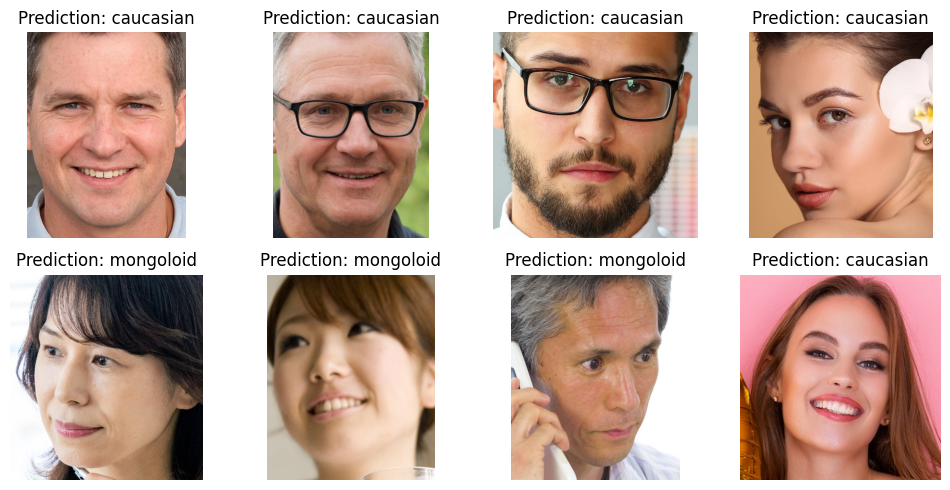

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()